In [16]:
import warnings
import itertools
import pandas as pd
import plotting as mp
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [17]:
project_name = 'project_6d8c'
filelocation='../../capstone_data/Azimuth/clean/{}_featurized.csv'.format(project_name)
df = pd.read_csv(filelocation)
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')
df.set_index('t',inplace=True)

In [18]:
df['power_1'] = df['load_v1rms'] * df['load_i1rms'] 
df['power_2'] = df['load_v2rms'] * df['load_i2rms'] 
df['power_3'] = df['load_v3rms'] * df['laod_i3rms'] 
df['power_all'] = df['power_1'] +df['power_2']+df['power_3']

In [19]:
# df2 = df.loc['2017-01-10 00:00:00':]
y = pd.DataFrame(df['power_all'])

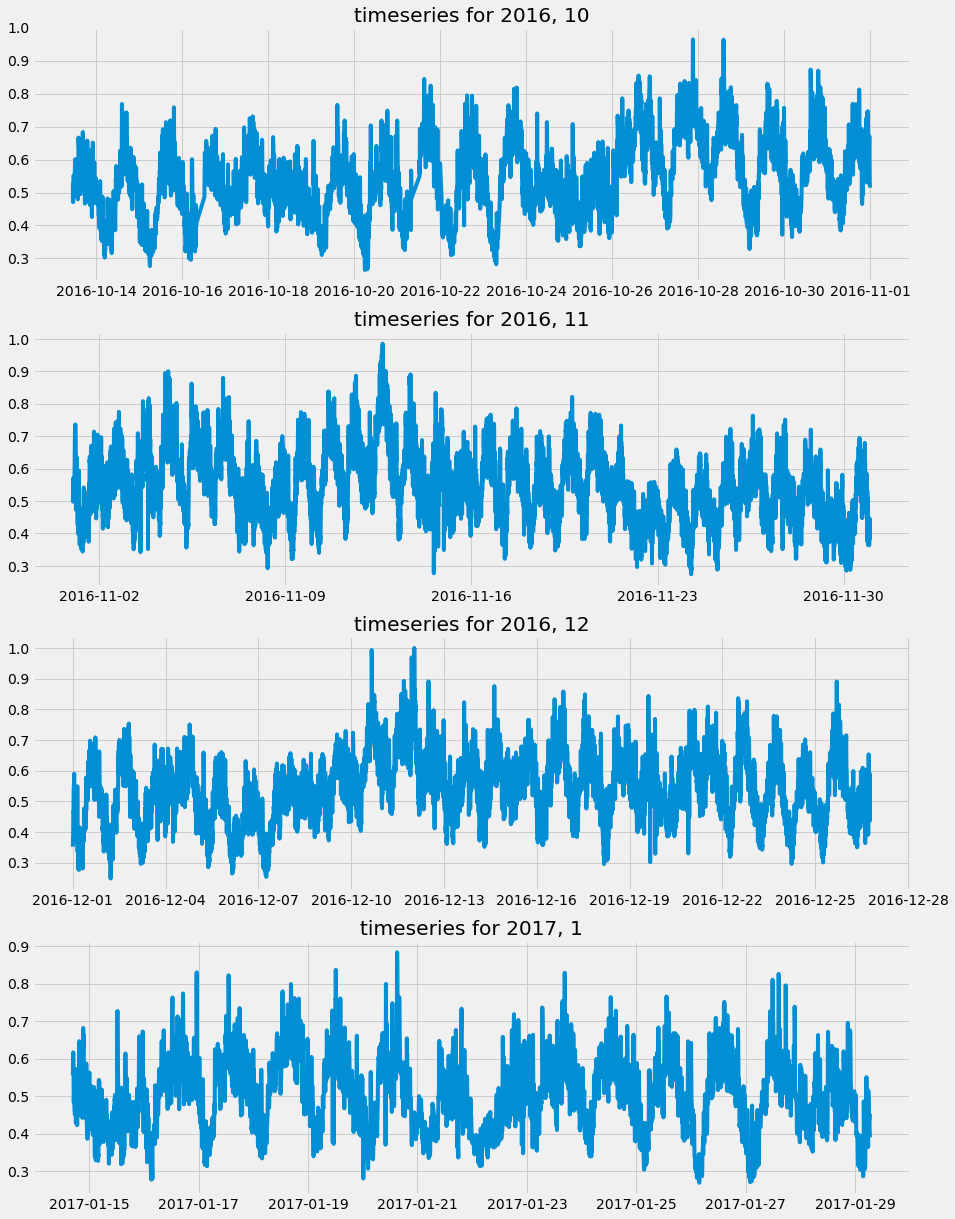

In [20]:
mp.plot_all_data(df,['power_all'])

In [21]:
y = y['power_all'].resample('H').mean()

In [22]:
y = y.fillna(y.bfill())

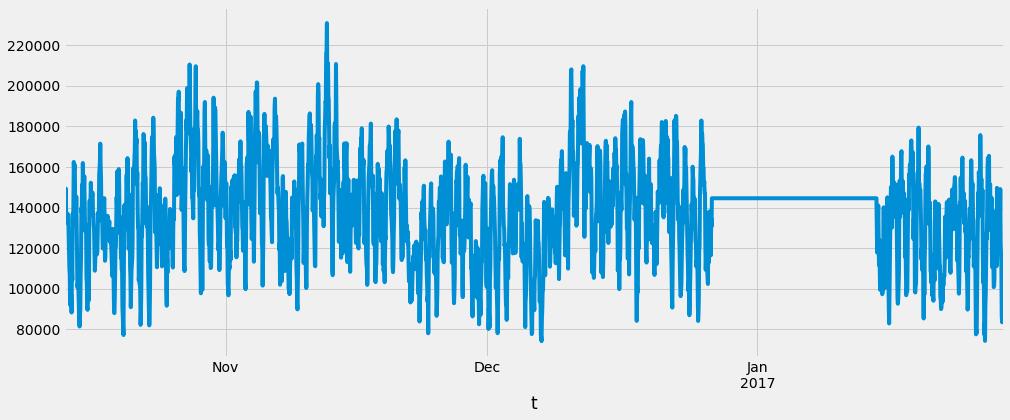

In [23]:
y.plot(figsize=(15, 6))
plt.show()

# Trend Seasonal Residual Decomposition

In [24]:
python_decomposition = sm.tsa.seasonal_decompose(y)
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

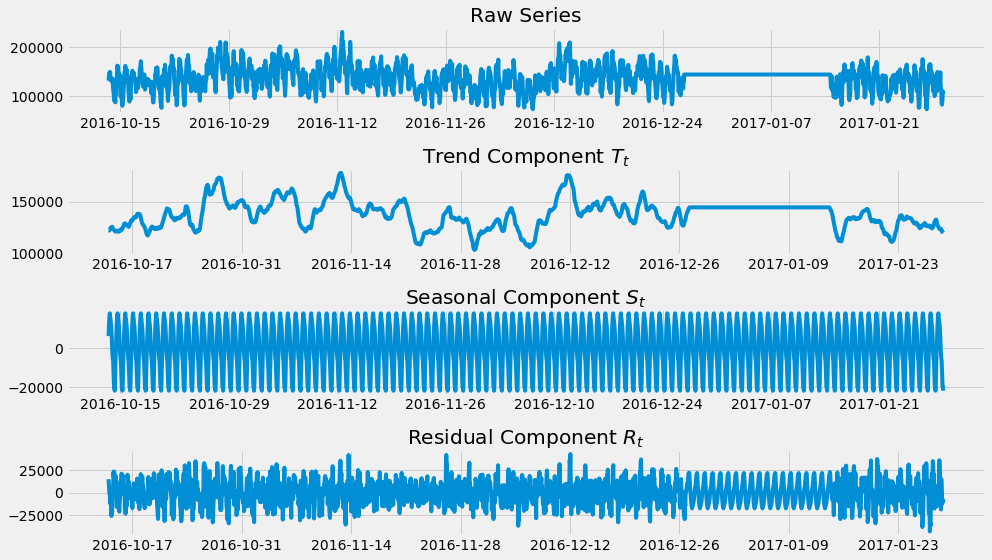

In [25]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, y, python_decomposition)
plt.tight_layout()
plt.show()

## Differencing

In [46]:
d = 24

In [47]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff(d)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

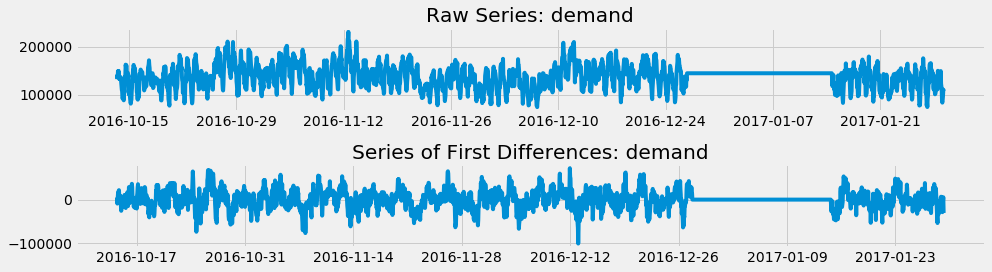

In [48]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, y, 'demand')
fig.tight_layout()
plt.show()

In [49]:
test = sm.tsa.stattools.adfuller(y)
print("ADF p-value for demand series: {0:2.2f}".format(test[1]))

ADF p-value for demand series: 0.00


In [51]:
test = sm.tsa.stattools.adfuller(y.diff(d)[d:])
print("ADF p-value for differenced demand series: {0:2.2f}".format(test[1]))

ADF p-value for differenced demand series: 0.00


## Auto correlation plots

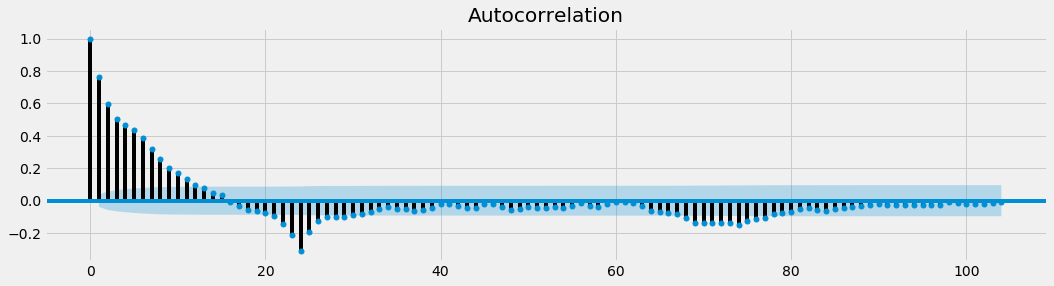

In [52]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(y.diff(d)[d:], lags=2*52, ax=ax)

plt.show()

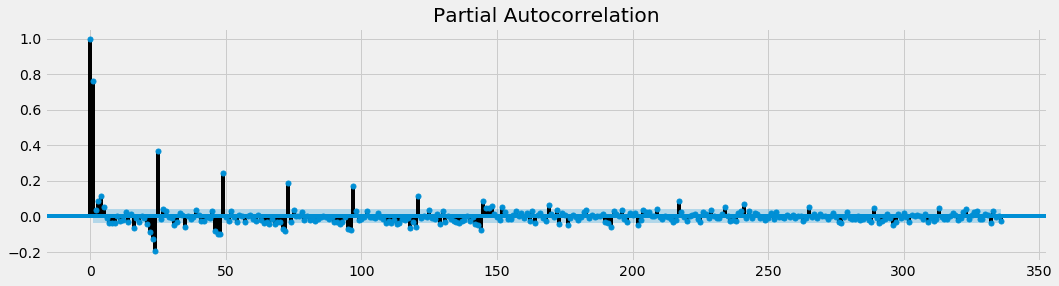

In [53]:
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(y.diff(d)[d:], lags=14*24, ax=ax)
plt.show()

## Fitting SARIMA

In [104]:
params = (3,1,1)
seasonal_params = (3,0,1,24)
mod = sm.tsa.statespace.SARIMAX(y,order=params,seasonal_order=seasonal_params,
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{} - AIC:{}'.format(params, seasonal_params, results.aic))

ARIMA(3, 1, 1)x(3, 0, 1, 24) - AIC:53608.323466


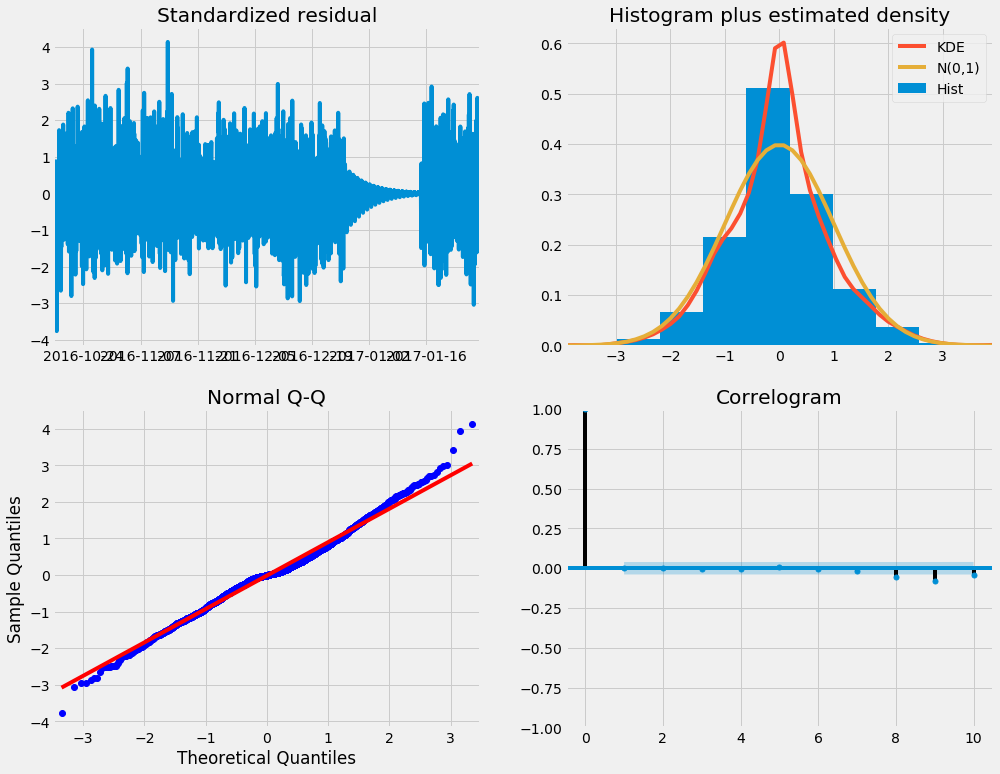

In [105]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [57]:
pred = results.get_prediction(start=y[-48:].index[0], dynamic=False)
pred_ci = pred.conf_int()

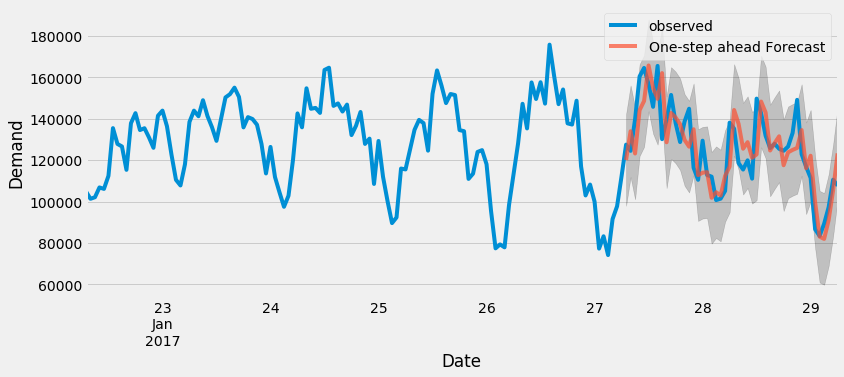

In [58]:
ax = y[-168:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12,5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [60]:
y_forecasted = pred.predicted_mean
y_truth = y[-48:]

# Compute the mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 12381.74


In [62]:
pred_dynamic = results.get_prediction(start=y[-48:].index[0], dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

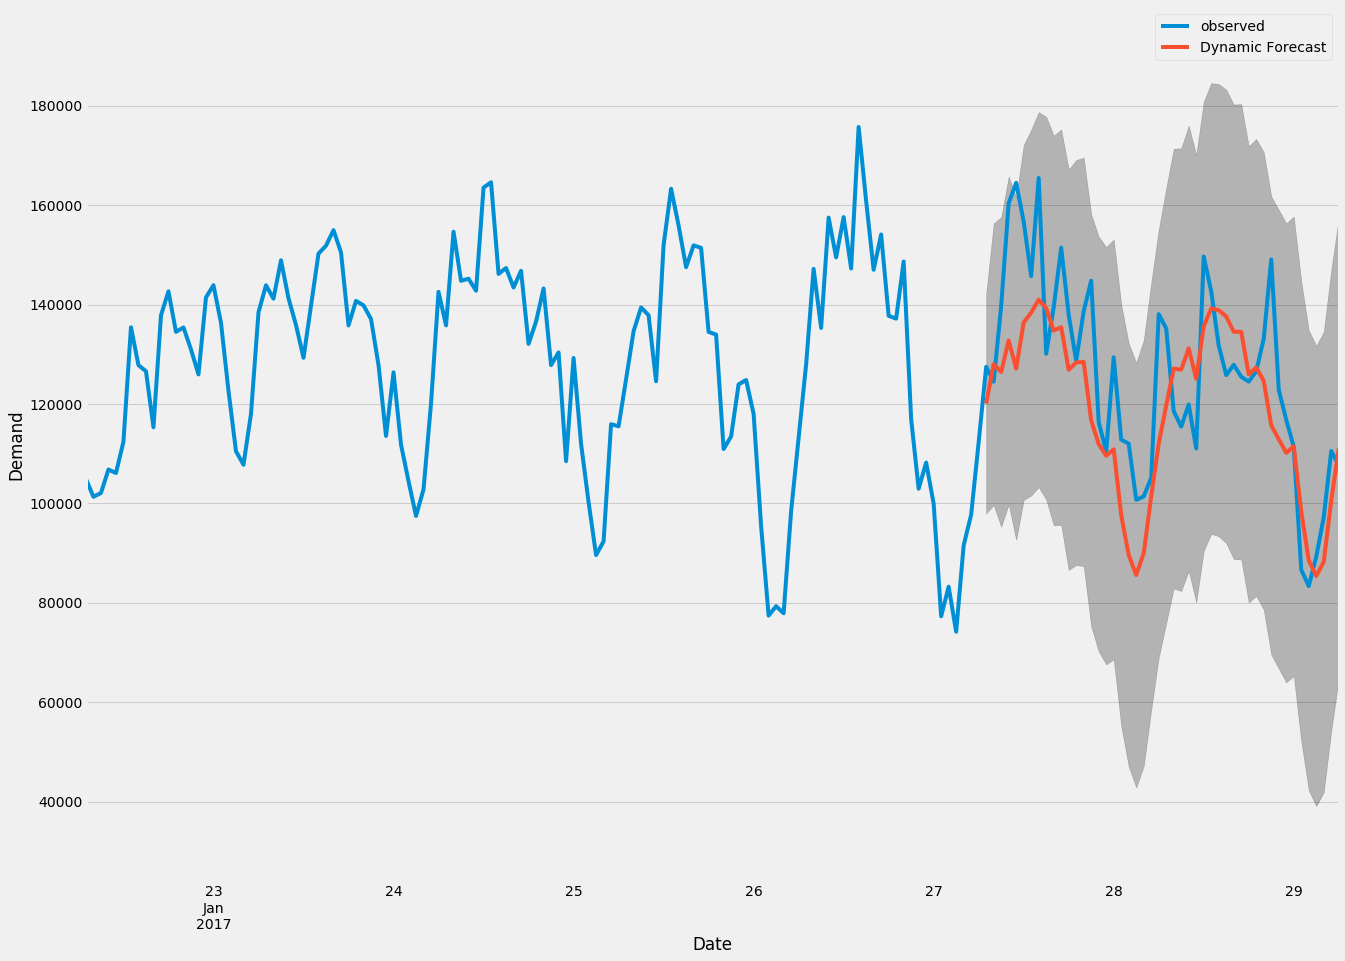

In [64]:
ax = y[-168:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-15'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

## Fitting SARIMA with pre-diff

In [65]:
y_diff = y.diff(24)[(24):]
params = (3,0,1)
seasonal_params = (3,0,1,24)
mod = sm.tsa.statespace.SARIMAX(y_diff,order=params,seasonal_order=seasonal_params,
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}2016 - AIC:{}'.format(params, seasonal_params, results.aic))

ARIMA(3, 0, 1)x(3, 0, 1, 24)2016 - AIC:53258.4727207


In [66]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3016      0.171      7.617      0.000       0.967       1.637
ar.L2         -0.4606      0.133     -3.472      0.001      -0.721      -0.201
ar.L3          0.0952      0.036      2.681      0.007       0.026       0.165
ma.L1         -0.5102      0.173     -2.947      0.003      -0.850      -0.171
ar.S.L24       0.0804      0.037      2.182      0.029       0.008       0.153
ar.S.L48      -0.0162      0.035     -0.456      0.649      -0.086       0.053
ar.S.L72      -0.0369      0.034     -1.081      0.280      -0.104       0.030
ma.S.L24      -0.8853      0.022    -40.353      0.000      -0.928      -0.842
sigma2      1.693e+08   8.45e-11      2e+18      0.000    1.69e+08    1.69e+08


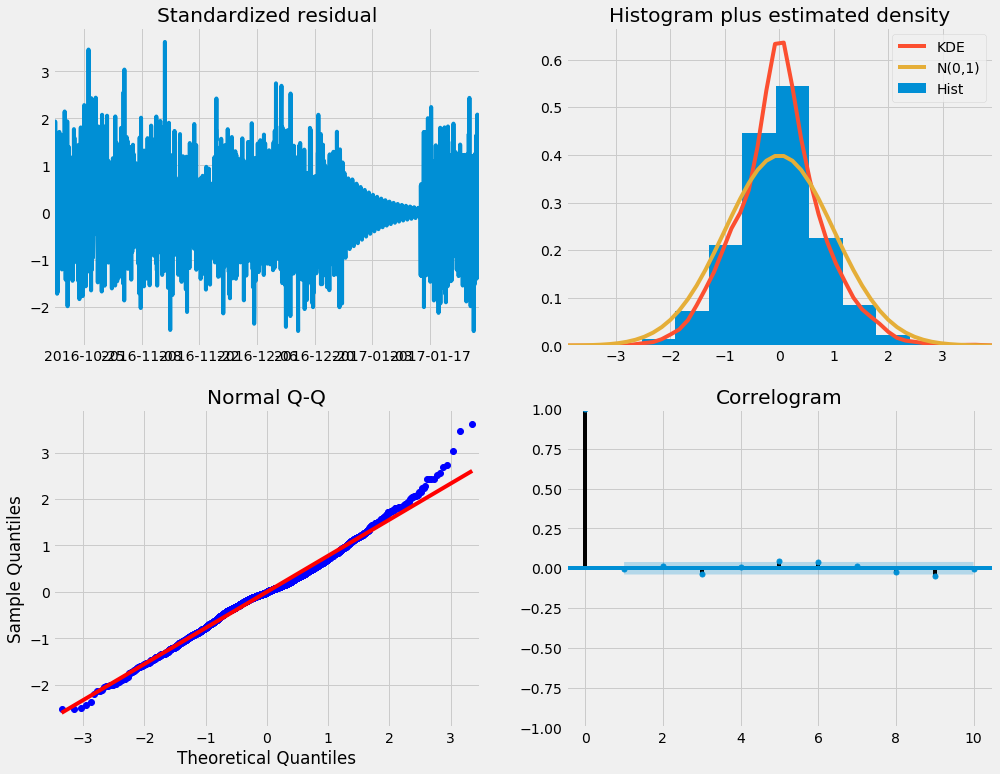

In [67]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [69]:
pred = results.get_prediction(start=y_diff[-24:].index[0], dynamic=False)
pred_ci = pred.conf_int()

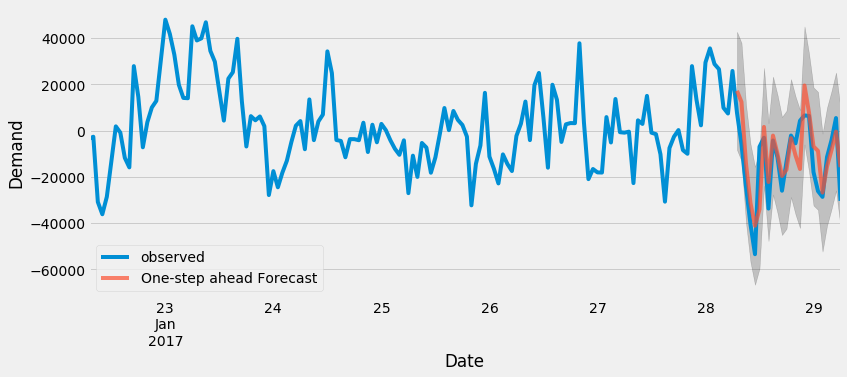

In [70]:

ax = y_diff[-168:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12,5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [101]:
y_forecasted = pred.predicted_mean
y_truth = y_diff[-24:]

# Compute the mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 11276.56


## Reconstruction

In [102]:
def one_ahead_reconstruction(y_pred, y_true):
    new_preds = np.zeros(len(y_pred))
    for i in range(len(new_preds)):
        date = y_pred.index[i]
        previous = y_true[date - pd.Timedelta(days=1)]
        new_preds[i] = y_pred.values[i] + previous
    return new_preds

y_forecasted = one_ahead_reconstruction(y_forecasted, y)

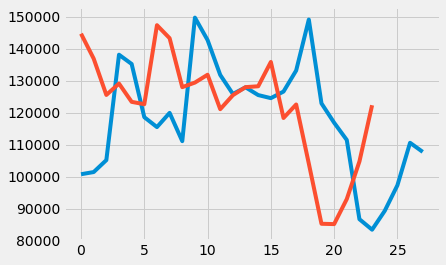

In [103]:
plt.plot(y[-28:].values)
plt.plot(y_forecasted)
plt.show()

In [72]:
pred_dynamic = results.get_prediction(start=y_diff[-24:].index[0], dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

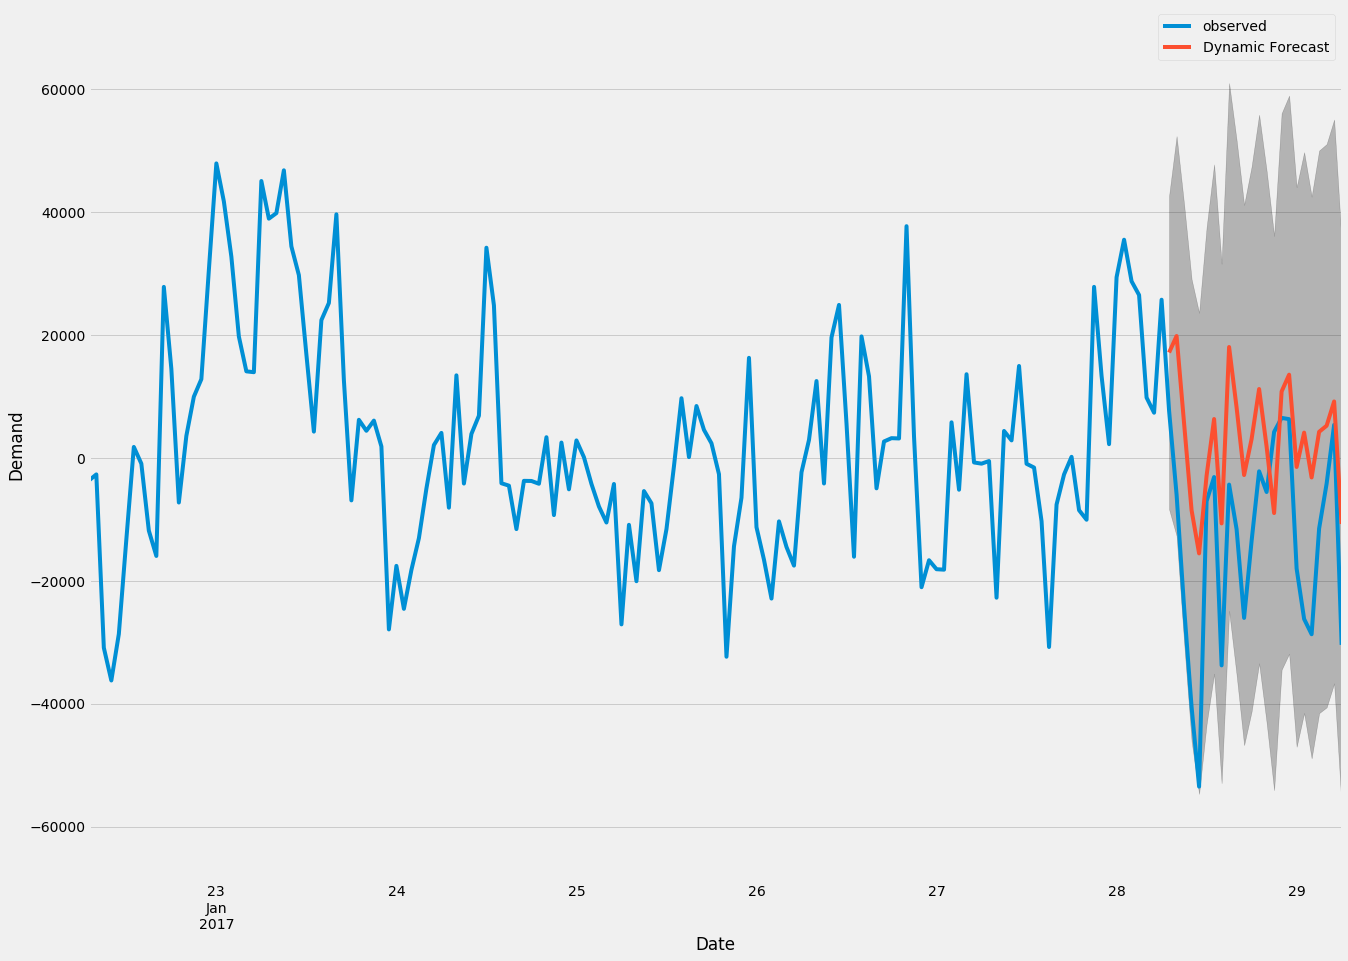

In [73]:
ax = y_diff[-168:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-15'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

### reconstructing the difference.... need a starting week to do so

It worked!!


In [217]:
preds = pred_dynamic.predicted_mean
new_preds = np.zeros(len(preds))
for i in range(len(preds)):
    date = preds.index[i]
#     diff1 = y[date - pd.Timedelta(days=7)]-y[date - pd.Timedelta(days=8)]
    diff2 = y[date - pd.Timedelta(days=1)]
    new_preds[i] = preds.values[i] +  diff2
# y[preds.index[0]-pd.Timedelta(days=1):]
y_true = y[preds.index[0]:].values

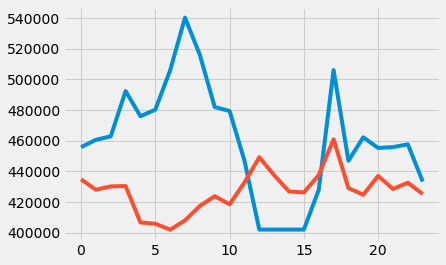

In [218]:
plt.plot(y_true[:24])
plt.plot(new_preds[:24])
plt.show()

## Check that it is working correctly

In [205]:
x = y.diff(24).diff(168)[192:]
new_preds = np.zeros(len(x))
for i in range(len(x)-1):
    date = x.index[i]
    diff1 = y[date - pd.Timedelta(days=7)]-y[date - pd.Timedelta(days=8)]
    diff2 = y[date - pd.Timedelta(days=1)]
    new_preds[i] = x.values[i] + diff1 + diff2
y_true = y[192:].values

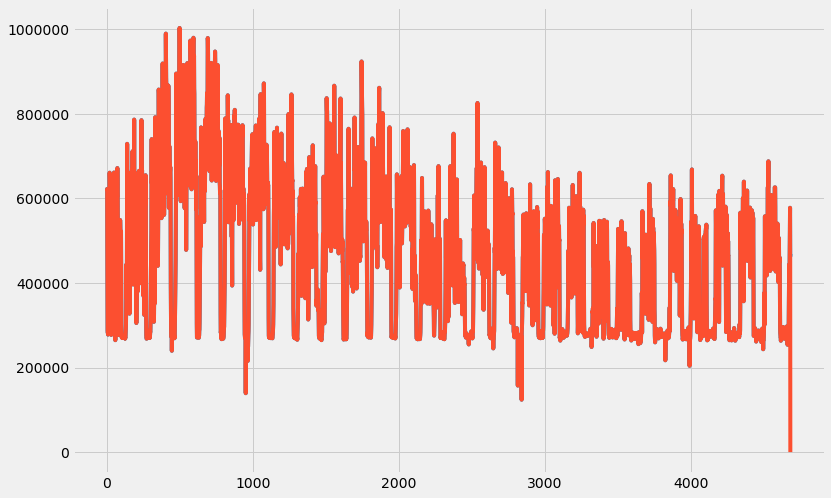

In [206]:
plt.figure(figsize=(12,8))
plt.plot(y_true)
plt.plot(new_preds)
plt.show()

## Create Function

In [219]:
def reconstruct_day_week(preds, y_true):
    new_preds = np.zeros(len(preds))
    for i in range(len(new_preds)):
        date = preds.index[i]
        diff1 = y_true[date - pd.Timedelta(days=7)]-y_true[date - pd.Timedelta(days=8)]
        diff2 = y_true[date - pd.Timedelta(days=1)]
        new_preds[i] = preds.values[i] + diff1 + diff2
    return new_preds

def reconstruct_day(preds, y_true):
    new_preds = np.zeros(len(preds))
    for i in range(len(new_preds)):
        date = preds.index[i]
        diff1 = 0
        diff2 = y_true[date - pd.Timedelta(days=1)]
        new_preds[i] = preds.values[i] + diff1 + diff2
    return new_preds

In [220]:
preds = pred_dynamic.predicted_mean
new_preds = np.zeros(len(preds))
new_p = reconstruct_day(preds, y)

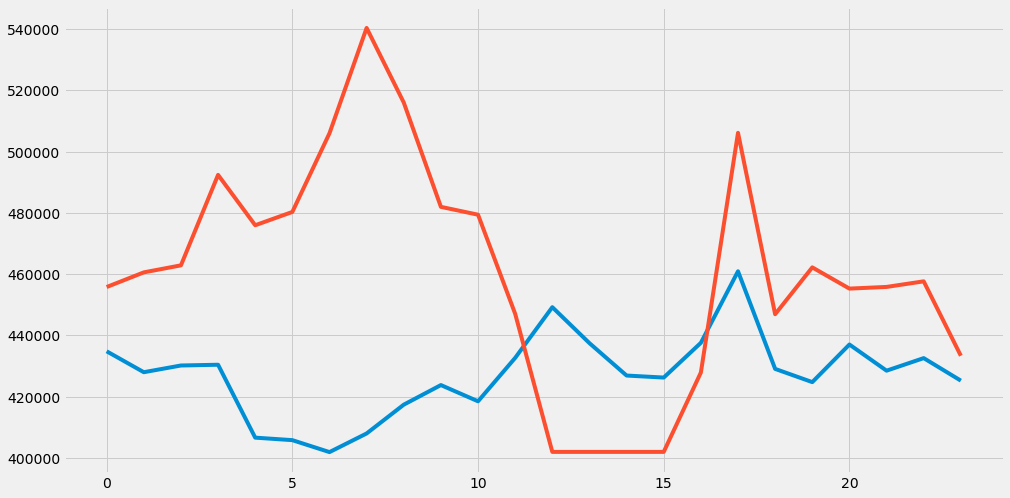

In [221]:
plt.figure(figsize=(15,8))
plt.plot(new_p[:24])
plt.plot(y[preds.index[0]:].values[:24])
plt.show()